# Claude3 - Sonnet
- Claude3이 되면서 기존 Claude2/2.1에서 사용하는 prompt 메시지 방식이 새롭게 개선되었습니다.
- 새로운 메시지 API는 아래와 같은 주요 이점을 제공합니다:
  - 이미지 처리: 메시지 API는 Claude로 이미지를 처리할 수 있는 유일한 방법으로, 이미지 분류, 물체 감지 등과 같은 작업에 고급 컴퓨터 비전 기능을 활용할 수 있습니다.
  - Claude 3 모델로 구축하기: 가장 강력한 최신 Claude 3 모델은 메시지 API를 통해서만 호출할 수 있습니다. 업그레이드를 통해 향상된 성능과 기능을 활용할 수 있습니다.
  - 향상된 오류 처리: 메시지 API를 사용하면 더욱 유익하고 유용한 오류 메시지를 반환할 수 있으므로 요청의 문제를 더 쉽게 진단하고 해결할 수 있습니다.
  - 요청 유효성 검사 개선: 메시지 API를 사용하면 사용자의 API 요청을 보다 효과적으로 검증할 수 있으므로, 사용자가 모델에서 최고 품질의 결과와 최상의 성능을 얻을 수 있습니다.
- 참고 자료 
  - https://docs.anthropic.com/claude/docs/upgrading-from-the-text-completions-api
  - https://docs.anthropic.com/claude/reference/messages_post

In [1]:
!pip install -U boto3 botocore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 151.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.55
    Uninstalling botocore-1.34.55:
      Successfully uninstalled botocore-1.34.55
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.55
    Uninstalling boto3-1.34.55:
      Successfully uninstalled boto3-1.34.55
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.1 requires botocore<1.34.52,>=1.34.41, but you have botocore 1.34.56 which is incompatible.
awscli 1.32.50 requires botocore==1.34.50, but you have botocore 1.34.56 which is incompatible.


## 1. Bedrock 호출 함수 선언

In [2]:
import boto3
import os
import json
from botocore.config import Config
import botocore 

session = boto3.Session()

retry_config = Config(
    region_name=os.environ.get("AWS_DEFAULT_REGION", None),
    retries={
        "max_attempts": 10,
        "mode": "standard",
    },
)

# modelId = "anthropic.claude-instant-v1"  # (Change this to try different model versions)
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = "application/json"
contentType = "application/json"

bedrock_runtime = boto3.client(service_name='bedrock-runtime',config=retry_config)


def bedrock_streemer(response):
    stream = response.get('body')
    answer = ""
    i = 1
    if stream:
        for event in stream:
            chunk = event.get('chunk')
            if  chunk:
                chunk_obj = json.loads(chunk.get('bytes').decode())
                if "delta" in chunk_obj:                    
                    delta = chunk_obj['delta']
                    if "text" in delta:
                        text=delta['text'] 
                        print(text, end="")
                        answer+=str(text)       
                        i+=1
    return answer

def call_claude_sonet(prompt, base64_string=None, streaming=True):
    if base64_string is None:
        prompt_config = {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 4096,
            "temperature" : 0,
            "top_k": 350,
            "top_p": 0.999,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                    ],
                }
            ],
        }
    else:
        prompt_config = {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 4096,
            "temperature" : 0,
            "top_k": 350,
            "top_p": 0.999,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/png",
                                "data": base64_string,
                            },
                        },
                        {"type": "text", "text": prompt},
                    ],
                }
            ],
        }


    body = json.dumps(prompt_config)

    modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
    accept = "application/json"
    contentType = "application/json"
    
    if streaming:
        
        response = bedrock_runtime.invoke_model_with_response_stream(
            body=body, modelId=modelId, accept=accept, contentType=contentType
        )
        results=bedrock_streemer(response)
    else:
        response = bedrock_runtime.invoke_model(
            body=body, modelId=modelId, accept=accept, contentType=contentType
        )
        response_body = json.loads(response.get("body").read())
        results = response_body.get("content")[0].get("text")
    return results


def image_to_base64(img):
    import base64
    """Converts a PIL Image or local image file path to a base64 string"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")

# def perform_qa(question, text, streaming=True):
#     """
#     Function to perform a Q&A operation based on the provided text.
#     """
#     prompt = f"Given the following text, answer the question. If the answer is not in the text, 'say you do not know': {question} text: {text} "
#     result = call_claude_sonet(prompt, streaming)
#     return result

## 2. Prompt를 이용한 Text 및 table 이미지 테스트


In [3]:
prompt = "나는 인공지능 AI 보험 서비스입니다. 생명과 손해 보험의 차이에 대해 설명해 주세요."
call_claude_sonet(prompt)

생명보험과 손해보험은 보험의 주요 유형으로 다음과 같은 차이점이 있습니다.

1. 보장 대상
- 생명보험은 사람의 생명과 관련된 위험을 보장합니다. 예를 들어 사망, 상해, 질병 등을 대상으로 합니다.
- 손해보험은 재산상의 손해나 배상책임을 보장합니다. 예를 들어 화재, 자동차사고, 배상책임 등을 대상으로 합니다.

2. 보험금 지급 사유
- 생명보험은 피보험자의 사망, 상해, 질병 등 인적 위험이 발생했을 때 보험금을 지급합니다.
- 손해보험은 재물의 손해나 제3자에 대한 배상책임이 발생했을 때 실제 입은 손해를 보상합니다.

3. 보험기간
- 생명보험은 일반적으로 장기계약이며, 종신보험의 경우 피보험자 종신까지 보장됩니다.
- 손해보험은 단기계약이 일반적이며, 1년 만기로 갱신하는 경우가 많습니다.

4. 보험료 산정 기준
- 생명보험료는 피보험자의 나이, 건강상태, 가입금액 등에 따라 결정됩니다.
- 손해보험료는 보험목적물의 가액, 위험률, 보상한도 등에 따라 결정됩니다.

요약하면 생명보험은 개인의 생명과 관련된 위험을 장기적으로 보장하고, 손해보험은 재산상 손해나 배상책임을 단기적으로 보상하는 차이가 있습니다.

'생명보험과 손해보험은 보험의 주요 유형으로 다음과 같은 차이점이 있습니다.\n\n1. 보장 대상\n- 생명보험은 사람의 생명과 관련된 위험을 보장합니다. 예를 들어 사망, 상해, 질병 등을 대상으로 합니다.\n- 손해보험은 재산상의 손해나 배상책임을 보장합니다. 예를 들어 화재, 자동차사고, 배상책임 등을 대상으로 합니다.\n\n2. 보험금 지급 사유\n- 생명보험은 피보험자의 사망, 상해, 질병 등 인적 위험이 발생했을 때 보험금을 지급합니다.\n- 손해보험은 재물의 손해나 제3자에 대한 배상책임이 발생했을 때 실제 입은 손해를 보상합니다.\n\n3. 보험기간\n- 생명보험은 일반적으로 장기계약이며, 종신보험의 경우 피보험자 종신까지 보장됩니다.\n- 손해보험은 단기계약이 일반적이며, 1년 만기로 갱신하는 경우가 많습니다.\n\n4. 보험료 산정 기준\n- 생명보험료는 피보험자의 나이, 건강상태, 가입금액 등에 따라 결정됩니다.\n- 손해보험료는 보험목적물의 가액, 위험률, 보상한도 등에 따라 결정됩니다.\n\n요약하면 생명보험은 개인의 생명과 관련된 위험을 장기적으로 보장하고, 손해보험은 재산상 손해나 배상책임을 단기적으로 보상하는 차이가 있습니다.'

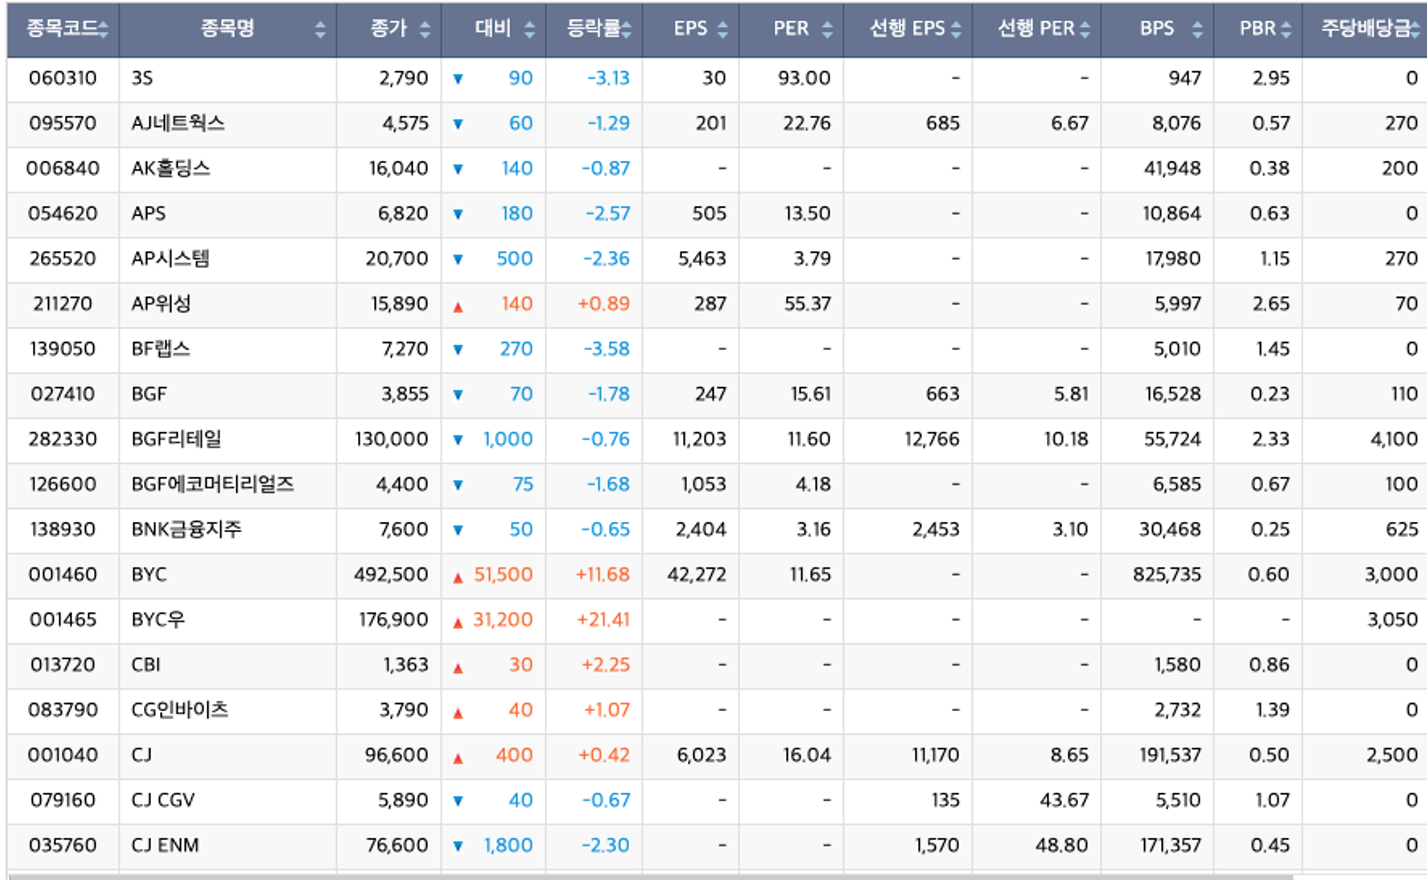

In [4]:
from PIL import Image
image_path = 'profit_table.png'
Image.open(image_path)

In [5]:
prompt = "Provide a caption for this image"
prompt = "AP위성의 종가가 어떻게 되나요?"
base64_string = image_to_base64(image_path)
call_claude_sonet(prompt, base64_string)

Reading image from file: profit_table.png
AP위성의 종가는 15,890원입니다. 해당 표에서 AP위성의 종목코드는 211270이며, 종가 열에 15,890원으로 기재되어 있습니다.

'AP위성의 종가는 15,890원입니다. 해당 표에서 AP위성의 종목코드는 211270이며, 종가 열에 15,890원으로 기재되어 있습니다.'

## 3. Multi-turn을 고려한 Message 전달 방식 테스트

In [6]:
def call_claude_sonet_msg(messages, streaming=True):
    prompt_config = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 4096,
        "temperature" : 0,
        "top_k": 350,
        "top_p": 0.999,
        "messages": messages,
    }


    body = json.dumps(prompt_config)

    modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
    accept = "application/json"
    contentType = "application/json"
    
    if streaming:
        
        response = bedrock_runtime.invoke_model_with_response_stream(
            body=body, modelId=modelId, accept=accept, contentType=contentType
        )
        results=bedrock_streemer(response)
    else:
        response = bedrock_runtime.invoke_model(
            body=body, modelId=modelId, accept=accept, contentType=contentType
        )
        response_body = json.loads(response.get("body").read())
        results = response_body.get("content")[0].get("text")
    return results

In [7]:
prompt1 = "나는 인공지능 AI 보험 서비스입니다. 생명과 손해 보험의 차이에 대해 설명해 주세요."
messages = [
    {"role": "user", "content": [{"type": "text", "text": prompt1}]},
]

response = call_claude_sonet_msg(messages)
response

생명보험과 손해보험은 보험의 주요 유형으로 다음과 같은 차이점이 있습니다.

1. 보장 대상
- 생명보험은 사람의 생명과 관련된 위험을 보장합니다. 예를 들어 사망, 상해, 질병 등을 대상으로 합니다.
- 손해보험은 재산상의 손해나 배상책임을 보장합니다. 예를 들어 화재, 자동차사고, 배상책임 등을 대상으로 합니다.

2. 보험금 지급 사유
- 생명보험은 피보험자의 사망, 상해, 질병 등 인적 위험이 발생했을 때 보험금을 지급합니다.
- 손해보험은 재물의 손해나 제3자에 대한 배상책임이 발생했을 때 실제 입은 손해를 보상합니다.

3. 보험기간
- 생명보험은 일반적으로 장기계약이며, 종신보험의 경우 피보험자 종신까지 보장됩니다.
- 손해보험은 단기계약이 일반적이며, 1년 만기로 갱신하는 경우가 많습니다.

4. 보험료 산정 기준
- 생명보험료는 피보험자의 나이, 건강상태, 가족력 등 인적위험을 기준으로 산정됩니다.
- 손해보험료는 보험목적물의 가액, 위험률 등 물적위험을 기준으로 산정됩니다.

요약하면, 생명보험은 개인의 생명과 관련된 위험을 장기적으로 보장하고, 손해보험은 재산상의 손해나 배상책임을 단기적으로 보상하는 차이가 있습니다.

'생명보험과 손해보험은 보험의 주요 유형으로 다음과 같은 차이점이 있습니다.\n\n1. 보장 대상\n- 생명보험은 사람의 생명과 관련된 위험을 보장합니다. 예를 들어 사망, 상해, 질병 등을 대상으로 합니다.\n- 손해보험은 재산상의 손해나 배상책임을 보장합니다. 예를 들어 화재, 자동차사고, 배상책임 등을 대상으로 합니다.\n\n2. 보험금 지급 사유\n- 생명보험은 피보험자의 사망, 상해, 질병 등 인적 위험이 발생했을 때 보험금을 지급합니다.\n- 손해보험은 재물의 손해나 제3자에 대한 배상책임이 발생했을 때 실제 입은 손해를 보상합니다.\n\n3. 보험기간\n- 생명보험은 일반적으로 장기계약이며, 종신보험의 경우 피보험자 종신까지 보장됩니다.\n- 손해보험은 단기계약이 일반적이며, 1년 만기로 갱신하는 경우가 많습니다.\n\n4. 보험료 산정 기준\n- 생명보험료는 피보험자의 나이, 건강상태, 가족력 등 인적위험을 기준으로 산정됩니다.\n- 손해보험료는 보험목적물의 가액, 위험률 등 물적위험을 기준으로 산정됩니다.\n\n요약하면, 생명보험은 개인의 생명과 관련된 위험을 장기적으로 보장하고, 손해보험은 재산상의 손해나 배상책임을 단기적으로 보상하는 차이가 있습니다.'

In [8]:
prompt2 = "대상을 좀더 상세히 설명해 주세요"
messages = [
    {"role": "user", "content": [{"type": "text", "text": prompt1}]},
    {"role": "assistant", "content": response},
    {"role": "user", "content": [{"type": "text", "text": prompt2}]},
]

response = call_claude_sonet_msg(messages)
response

네, 생명보험과 손해보험의 보장 대상을 좀 더 자세히 설명드리겠습니다.

생명보험:
- 사망보험: 피보험자가 사망했을 때 보험금을 지급합니다.
- 상해보험: 피보험자가 재해로 인한 상해를 입었을 때 보험금을 지급합니다.
- 질병보험: 피보험자가 특정 질병에 걸렸을 때 보험금을 지급합니다. 
- 건강보험: 피보험자의 상해나 질병 치료비를 보상합니다.
- 연금보험: 노후 소득보장을 위해 일정기간 보험료를 납입하고 연금을 지급받습니다.

손해보험:
- 화재보험: 건물, 가재도구 등의 화재 손해를 보상합니다.
- 해상보험: 선박, 화물 등의 해상 운송 위험을 보상합니다. 
- 자동차보험: 자동차 사고로 인한 차량 손해와 대인/대물 배상책임을 보상합니다.
- 배상책임보험: 제3자에 대한 법률상 배상책임 위험을 보상합니다.
- 기술보험: 기계, 전자기기 등의 성능, 하자 위험을 보상합니다.
- 종합보험: 기업의 각종 재산상 위험과 배상책임을 포괄적으로 보상합니다.

이처럼 생명보험은 개인의 생명과 건강 위험을, 손해보험은 재물 손해와 배상책임 위험을 주된 보장 대상으로 합니다.

'네, 생명보험과 손해보험의 보장 대상을 좀 더 자세히 설명드리겠습니다.\n\n생명보험:\n- 사망보험: 피보험자가 사망했을 때 보험금을 지급합니다.\n- 상해보험: 피보험자가 재해로 인한 상해를 입었을 때 보험금을 지급합니다.\n- 질병보험: 피보험자가 특정 질병에 걸렸을 때 보험금을 지급합니다. \n- 건강보험: 피보험자의 상해나 질병 치료비를 보상합니다.\n- 연금보험: 노후 소득보장을 위해 일정기간 보험료를 납입하고 연금을 지급받습니다.\n\n손해보험:\n- 화재보험: 건물, 가재도구 등의 화재 손해를 보상합니다.\n- 해상보험: 선박, 화물 등의 해상 운송 위험을 보상합니다. \n- 자동차보험: 자동차 사고로 인한 차량 손해와 대인/대물 배상책임을 보상합니다.\n- 배상책임보험: 제3자에 대한 법률상 배상책임 위험을 보상합니다.\n- 기술보험: 기계, 전자기기 등의 성능, 하자 위험을 보상합니다.\n- 종합보험: 기업의 각종 재산상 위험과 배상책임을 포괄적으로 보상합니다.\n\n이처럼 생명보험은 개인의 생명과 건강 위험을, 손해보험은 재물 손해와 배상책임 위험을 주된 보장 대상으로 합니다.'

In [9]:
messages = [
  {"role": "user", "content": "추천 상품으로 가장 적합한 것은? A. 햄버거 B. 탕수육 C. 제육덮밥"},
  {"role": "assistant", "content": "가장 좋은 답변은 ("},
]
response = call_claude_sonet_msg(messages)
response

C) 제육덮밥입니다.

제육덮밥은 한국 전통 음식으로 영양가가 높고 맛도 좋습니다. 햄버거나 탕수육보다 건강에 더 좋은 선택이 될 수 있습니다. 또한 제육덮밥은 한국 문화를 대표하는 음식이기도 합니다. 

하지만 개인의 기호에 따라 다른 선택을 할 수도 있겠죠. 햄버거나 탕수육도 맛있는 음식이니까요. 중요한 것은 균형 잡힌 식단을 유지하면서 자신이 좋아하는 음식을 즐기는 것입니다.

'C) 제육덮밥입니다.\n\n제육덮밥은 한국 전통 음식으로 영양가가 높고 맛도 좋습니다. 햄버거나 탕수육보다 건강에 더 좋은 선택이 될 수 있습니다. 또한 제육덮밥은 한국 문화를 대표하는 음식이기도 합니다. \n\n하지만 개인의 기호에 따라 다른 선택을 할 수도 있겠죠. 햄버거나 탕수육도 맛있는 음식이니까요. 중요한 것은 균형 잡힌 식단을 유지하면서 자신이 좋아하는 음식을 즐기는 것입니다.'

In [10]:
text_prompt1 = "이미지 table에서 나온 내용을 정확히 분석해서 환각이 없도록 설명해줘. CG인바이츠의 종가는 얼마야"
messages = [
  {"role": "user", "content": [
      {"type": "image","source" : {"type" : "base64", "media_type": "image/png","data": image_to_base64(image_path)}}, 
      {"type": "text", "text": text_prompt1}]}
]
response = call_claude_sonet_msg(messages)
response

Reading image from file: profit_table.png
이미지에서 CG인바이츠의 종가는 3,790원입니다. 해당 종목의 종목코드는 083790이며, 전일 대비 40원 상승한 것으로 나타납니다.

'이미지에서 CG인바이츠의 종가는 3,790원입니다. 해당 종목의 종목코드는 083790이며, 전일 대비 40원 상승한 것으로 나타납니다.'

In [11]:
text_prompt2 = "BPS도 알려줘"
messages = [
    {"role": "user", "content": [
        {"type": "image","source" : {"type" : "base64", "media_type": "image/png","data": image_to_base64(image_path)}}, 
        {"type": "text", "text": text_prompt1}]},
    {"role": "assistant", "content": response},
    {"role": "user", "content": [{"type": "text", "text": text_prompt2}]},
]
response = call_claude_sonet_msg(messages)
response

Reading image from file: profit_table.png
표에 따르면 CG인바이츠 종목의 BPS(주당순자산가치)는 2,732원입니다.

'표에 따르면 CG인바이츠 종목의 BPS(주당순자산가치)는 2,732원입니다.'